# E207 Final Project: Vertical Jump Height Estimation

## Richie Harris

In [1]:
%matplotlib inline

### Imports

In [2]:
import numpy as np
import tensorflow as tf
import cv2
import time
import matplotlib.pyplot as plt
import glob
import subprocess
import os.path
import pickle
from collections import defaultdict

### Extract Time Series Data From Video Clip

Code adapted from Tensorflow Object Detection Framework
https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb
Tensorflow Object Detection Detector

In [3]:
class DetectorAPI:
    def __init__(self, path_to_ckpt):
        self.path_to_ckpt = path_to_ckpt

        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.compat.v1.GraphDef()
            with tf.io.gfile.GFile(self.path_to_ckpt, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')

        self.default_graph = self.detection_graph.as_default()
        self.sess = tf.compat.v1.Session(graph=self.detection_graph)

        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def processFrame(self, image):
        # Expand dimensions since the trained_model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image, axis=0)
        # Actual detection.
        start_time = time.time()
        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})
        end_time = time.time()

        print("Elapsed Time:", end_time-start_time)

        im_height, im_width,_ = image.shape
        boxes_list = [None for i in range(boxes.shape[1])]
        for i in range(boxes.shape[1]):
            boxes_list[i] = (int(boxes[0,i,0] * im_height),
                        int(boxes[0,i,1]*im_width),
                        int(boxes[0,i,2] * im_height),
                        int(boxes[0,i,3]*im_width))

        return boxes_list, scores[0].tolist(), [int(x) for x in classes[0].tolist()], int(num[0])

    def close(self):
        self.sess.close()
        self.default_graph.close()

In [4]:
def rotate(img, scaleFactor, degreesCCW):
    (oldY,oldX) = img.shape[:2] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=degreesCCW, scale=scaleFactor) #rotate about center of image.

    #choose a new image size.
    newX,newY = oldX*scaleFactor,oldY*scaleFactor
    #include this if you want to prevent corners being cut off
    r = np.deg2rad(degreesCCW)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    #the warpAffine function call, below, basically works like this:
    # 1. apply the M transformation on each pixel of the original image
    # 2. save everything that falls within the upper-left "dsize" portion of the resulting image.

    #So I will find the translation that moves the result to the center of that region.
    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty

    rotatedImg = cv2.warpAffine(img, M, dsize=(int(newX),int(newY)))
    return rotatedImg

In [5]:
def extractData(mp4file):
    """
    Extract the feet and head time series data from a video
    
    Arguments:
    mp4file: string containing the name of the video file
    
    Returns:
    feet: array containing the feet y coordinate time series data
    head: array containing the head y coordinate time series data
    """
    
    # neural net parameters
    model_path = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03/frozen_inference_graph.pb'
    odapi = DetectorAPI(path_to_ckpt=model_path)
    threshold = 0.3 # confidence threshold
    
    # capture each frame of the video
    cap = cv2.VideoCapture(mp4file)

    feet = [] # store y coordinates in pixels of feet of each frame
    head = [] # store y coordinate in pixels of head of each frame
    frame = 0 # frame counter

    while True:
        r, img = cap.read() # get the next frame
        if r == False: # no more frames in the video
            break
        else:
            img = cv2.resize(img, (1200, 700)) # resize to fit on screen
            img = rotate(img, 0.9, 270) # rotate image
            boxes, scores, classes, num = odapi.processFrame(img) # run the neural network

            boxScores = [] # confidence scores for all human classifications
            
            # Find all the classifications of humans above the confidence threshold.  Class 1 represents human
            for i in range(len(boxes)):
                if classes[i] == 1 and scores[i] > threshold:
                    boxScores += [scores[i]]

            # if we found at least one human, use the classification with the highest confidence score, and extract the
            # positions.  Print info about the detection
            if len(boxScores) > 0:        
                ind = boxScores.index(max(boxScores))
                box = boxes[ind]
                cv2.rectangle(img,(box[1],box[0]),(box[3],box[2]),(255,0,0),2)
                print("Score: ", scores[ind])
                print("frame: ", frame)
                print("")
                
                feet += [box[2]] # lower y coordinate of box
                head += [box[0]] # upper y coordinate of box
            
            # if there were no humans found, insert NONE for this frame
            elif len(boxScores) == 0:
                feet += [None]
                head += [None]
                
            # increment frame
            frame += 1
            
            # Visualize the results of the detection in real-time
            cv2.imshow("preview", img)
            
            # user can press 'q' to stop the process
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
    
    # stop showing the visualization
    cap.release()
    cv2.destroyAllWindows()
    
    return feet, head

## Construct the database and define the ground truth

In [6]:
def constructDB():
    """
    Iterate through each jump video in the directory and extract the time series data from each. 
    
    Arguments:
    None
    
    Returns:
    db:  dictionary containg the feet and head time series data for each jump video.  Key is a string of the file name,
         and the value is a tuple of two lists containing the data (feet, head)
    """
    
    directory = "videos"
    db = defaultdict(list)
    
    for jump in glob.glob(directory + '/*.mp4'): # iterate through each video in the directory
        feet, head = extractData(jump) # extract the time series data
        video_name = jump[(len(directory)+1):] # extract the song name (basename only) by slicing the path
        db[video_name].append((feet, head)) # append tuple with the data to the dictionary
    
    return db

In [7]:
def constructGT():
    """
    Construct the ground truth true jump heights for each video clip in the database.  This was done manually
    
    Arguments:
    none
    
    Returns:
    groundTruth:  dictionary containing true jump heights for each video.  Key is string of file name, value is height of jump
    """
    groundTruth = defaultdict(list)
    
    groundTruth["jump1.mp4"].append(20.39)
    groundTruth["jump2.mp4"].append(20.39)
    groundTruth["jump3.mp4"].append(15.50)
    groundTruth["jump4.mp4"].append(17.37)
    groundTruth["jump5.mp4"].append(20.39)
    groundTruth["jump6.mp4"].append(22.54)
    groundTruth["jump7.mp4"].append(16.42)
    groundTruth["jump8.mp4"].append(20.39)
    groundTruth["jump9.mp4"].append(16.42)
    groundTruth["jump10.mp4"].append(20.39)
    groundTruth["jump11.mp4"].append(14.60)
    groundTruth["jump12.mp4"].append(17.37)
    groundTruth["jump13.mp4"].append(14.60)
    groundTruth["jump14.mp4"].append(17.37)
    groundTruth["jump15.mp4"].append(13.73)
    groundTruth["jump16.mp4"].append(19.34)
    groundTruth["jump17.mp4"].append(19.34)
    groundTruth["jump18.mp4"].append(14.60)
    groundTruth["jump19.mp4"].append(17.34)
    groundTruth["jump20.mp4"].append(16.42)
    groundTruth["jump21.mp4"].append(17.37)
    groundTruth["jump22.mp4"].append(19.36)
    groundTruth["jump23.mp4"].append(19.36)
    groundTruth["jump24.mp4"].append(14.6)
    groundTruth["jump25.mp4"].append(14.6)
    groundTruth["jump26.mp4"].append(17.34)
    groundTruth["jump27.mp4"].append(18.35)
    groundTruth["jump28.mp4"].append(16.42)
    groundTruth["jump29.mp4"].append(15.50)
    groundTruth["jump30.mp4"].append(16.42)
    groundTruth["jump31.mp4"].append(15.50)
    groundTruth["jump32.mp4"].append(15.50)
    
    return groundTruth

Create the database and save for later, takes about 1-2 hours to run

In [8]:
db = constructDB()

KeyboardInterrupt: 

Save the results for later

In [69]:
with open('db.pkl','wb') as f:
    pickle.dump(db, f)

In [8]:
with open('db.pkl','rb') as f:
    db = pickle.load(f)

Define the ground truth jump heights for each video

In [9]:
groundTruth = constructGT()

## Plotting Functions

In [10]:
def plotData(feet, head):
    """
    Plot the time series feet and head data
    
    Arguments:
    feet: time series feet data
    head: time series head data
    
    Returns:
    none
    """

    # Mask the NaN values for frames without boxes
    xs = np.arange(len(feet))
    feetNP = np.array(feet).astype(np.double)
    feetMask = np.isfinite(feetNP)
    headNP = np.array(head).astype(np.double)
    headMask = np.isfinite(headNP)

    fig = plt.figure(figsize=(14, 6), dpi= 80) # size the plot
    plt.plot(xs[feetMask], feetNP[feetMask], linestyle = 'none', marker='o', label='feet')
    plt.plot(xs[headMask], headNP[headMask], linestyle = 'none',marker='o', label='head')
    plt.legend(loc='upper right')
    plt.ylabel('Distance From Top Of Frame (Pixels)')
    plt.xlabel('Frame Number')
    plt.show()

In [11]:
def plotEstimate(feet, f0, mu0, h, k, f1, mu1, length):
    """
    Plot the original data with the estimate overlayed
    
    Arguments:
    feet:  original data
    f0:  x coordinate of takeoff
    mu0:  y coordinate of takeoff
    h:  x coordinate of apex
    k:  y coordinate of apex
    f1:  x coordinate of landing
    mu1:  y coordinate of landing
    
    Returns:
    None
    """
    
    # Original data
    # Mask the NaN values for frames without boxes
    xs = np.arange(len(feet))
    feetNP = np.array(feet).astype(np.double)
    feetMask = np.isfinite(feetNP)
    
    # estimate
    xest = np.arange(length)
    yest = np.zeros(length)
    yest[0:f0] = mu0
    yp = createParabola(f0, mu0, h, k, f1, mu1)
    yest[f0:f1+1] = yp
    yest[f1:] = mu1

    fig = plt.figure(figsize=(14, 6), dpi= 80) # size the plot
    plt.plot(xs[feetMask], feetNP[feetMask], linestyle = 'none', marker='o', label='feet')
    plt.plot(xest, yest, marker='_', color='black', label='estimate')
    plt.legend(loc='upper right')
    plt.ylabel('Distance From Top Of Frame (Pixels)')
    plt.xlabel('Frame Number')
    plt.show()

Example plot

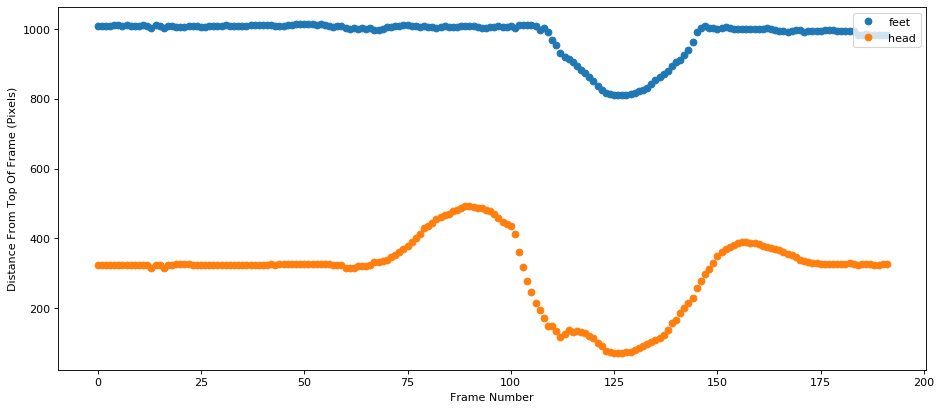

In [12]:
temp = db["jump1.mp4"]
feet = temp[0][0]
head = temp[0][1]
plotData(feet, head)

## Helper Functions

In [13]:
def createParabola(f0, mu0, h, k, f1, mu1):
    """
    A parabola can be uniquely defined by 3 unique points.  Create that parabola.
    Adapted from http://chris35wills.github.io/parabola_python/
    
    Arguments:
    f0:  x coordinate of first point
    mu0:  y coordinate of first point
    h:  x coordinate of second point
    k:  y coordinate of second point
    f1:  x coordinate of third point
    mu1:  y coordinate of third point
    
    Returns:
    y:  The unique parabola defined by (f0, mu0), (h, k), (f1, mu1)
    """
    
    # use the given three points to find A, B, C that satisfies y=ax^2+bx+c
    denom = (f0-h) * (f0-f1) * (h-f1);
    A     = (f1 * (k-mu0) + h * (mu0-mu1) + f0 * (mu1-k)) / denom;
    B     = (f1*f1 * (mu0-k) + h*h * (mu1-mu0) + f0*f0 * (k-mu1)) / denom;
    C     = (h * f1 * (h-f1) * mu0+f1 * f0 * (f1-f0) * k+f0 * h * (f0-h) * mu1) / denom;
    
    # now apply the equation to calculate values along the parabola between f0 and f1
    x = np.arange(f0, f1+1)
    y = np.zeros(f1-f0+1)
    y = (A*(x**2))+(B*x)+C
    
    return y

In [14]:
def createYhat(f0, mu0, h, k, f1, mu1, length):
    """
    create the piecewise estimate function for the jump given 6 parameters
    
    Arguments:
    f0:  x coordinate of takeoff point
    mu0:  pre-jump y coordinate mean
    h:  x coordinate of apex of jump
    k:  y coordinate of apex of jump
    f1:  x coordinate of landing point
    mu1:  post-jump y coordinate mean
    length:  total number of points
    
    Returns:
    yhat: the piecewise estimate function
    """
    
    yhat = np.zeros(length)
    
    yhat[0:f0] = mu0
    yp = createParabola(f0, mu0, h, k, f1, mu1)
    yhat[f0:f1+1] = yp
    yhat[f1:] = mu1
    
    return yhat

In [15]:
def calcError(f0, f1, h, k, length, feet):
    """
    Calculate the error between the model given by f0, f1 and the data.
    
    Arguments:
    f0: frame position of takeoff
    f1: frame position of landing
    h: frame of apex of jump
    k: vertical coordinate of apex of jump
    length: length of feet array
    feet: feet time series data
    
    Returns:
    error: the sum of squared residuals between the model and the data
    """
    
    # create model parameters
    mu0 = np.average(feet[0:f0+1])
    mu1 = np.average(feet[f1:])
    yhat = createYhat(f0, mu0, h, k, f1, mu1, length);
    # compute error
    error = np.sum((yhat-feet)**2)
    
    return error

## Maximum Liklihood Estimation (MLE) Algorithms

In [16]:
def mle_bf(feet, plot):
    """
    Run the maxmimum liklihood estimation algorithm on just the feet time series data.  Naive implementation - assumes
    that the minimum point in feet is the vertex.  Uses the brute force approach
    
    Arguments:
    feet:  feet time series data
    plot:  whether or not to generate a plot
    
    Returns:
    f0:  frame number at takeoff
    f1:  frame number at landing
    """
    
    length = len(feet) # number of frames
    minJump = 10 # 10 frames in the air is the minimum jump we allow (1.34 inches)

    # brute force exhaustive search of all possible f0 and f1
    minidx = np.argmin(feet)
    h = minidx
    k = feet[minidx]
    errors = np.ones((length, length)) # store all errors in a 2d matrix (rows, cols)
    errors = errors*1e10 # initialize to a high value so that unused elements in the array are not selected
    f0 = 0
    while f0 < (h - minJump/2):
        f1 = (h + minJump/2).astype(int)
        while f1 < length:
            errors[f0, f1] = calcError(f0, f1, h, k, length, feet)
            f1 += 1
        f0 += 1
    
    # find min error and the f0 and f1 that produced it
    minInd = np.unravel_index(np.argmin(errors, axis=None), errors.shape)
    (f0, f1) = minInd
    
    # plot the results
    if (plot==True):
        mu0 = np.average(feet[0:f0+1])
        mu1 = np.average(feet[f1:])
        plotEstimate(feet, f0, mu0, h, k, f1, mu1, length)
    
    return f0, f1

In [17]:
def mle_dp(feet, plot):
    """
    Optimizes for one parameter at a time, first optimize for mu0 and f0, then h and k, then mu1 and f1.  We still assume
    that (h,k) is the minimum value
    
    Arguments:
    feet:  time series feet data
    plot:  whether or not to generate a plot
    
    Returns:
    f0:  frame number at takeoff
    f1:  frame number at landing
    """
    
    length = len(feet) # number of frames
    minJump = 10 # 10 frames in the air is the minimum jump we allow (1.34 inches)
    minidx = np.argmin(feet)
    h = minidx
    k = feet[minidx]
    costs = np.ones((2, length)) # cumulative costs matrix, initialize to a high value so unused values aren't selected
    costs = costs*1e10
    
    # optimize for f0
    for f0 in list(range((h-minJump/2).astype(int))):
        # create model parameters
        mu0 = np.average(feet[0:f0+1])
        f1 = h + (h-f0) # dummy f1 to get a parabola that is symmetric about h
        if (f1 >= length): # make sure f1 does not exceed bounds of feet array
            f1 = length-1
        mu1 = np.average(feet[f1:])
        yhat = createYhat(f0, mu0, h, k, f1, mu1, length);
        # compute error up to h (first half of the jump because we are optimizing for f0 only)
        error =  0
        for i in list(range(h)):
            error += (yhat[i] - feet[i])**2
        costs[0,f0] = error
    
    f0 = np.argmin(costs, axis=1)[0]
    mu0 = np.average(feet[0:f0+1])
    
    # optimize for f1
    for f1 in list(range(((h+minJump/2).astype(int)),length)):
        # create model parameters
        mu1 = np.average(feet[f1:])
        yhat = createYhat(f0, mu0, h, k, f1, mu1, length);
        # compute error from h to the end (second half of the jump because we are optimizing for f1 only, and we have f0)
        error =  0
        for i in list(range(h,length)):
            error += (yhat[i] - feet[i])**2
        costs[1,f1] = error
    
    f1 = np.argmin(costs, axis=1)[1]
    mu1 = np.average(feet[f1:])
    
    # plot the results
    if (plot==True):
        mu0 = np.average(feet[0:f0+1])
        mu1 = np.average(feet[f1:])
        plotEstimate(feet, f0, mu0, h, k, f1, mu1, length)
    
    return f0, f1

In [18]:
def mle_gd1(feet, plot):
    """
    Uses the gradient descent to try to improve runtime from the brute force optimization while maintaining the same error
    rate.  We still assume that (h,k) is the minimum value
    
    Arguments:
    feet:  time series feet data
    plot:  whether or not to generate a plot
    
    Returns:
    f0:  frame number at takeoff
    f1:  frame number at landing
    """
    
    length = len(feet) # number of frames
    minJump = 10 # 10 frames in the air is the minimum jump we allow (1.34 inches)
    
    # gradient descent approach to optimization
    minidx = np.argmin(feet)
    h = minidx
    k = feet[minidx]
    errors = np.ones((length, length)) # store all errors in a 2d matrix (rows, cols)
    errors = errors*1e10 # initialize to a high value so that unused elements in the array are not selected
    
    # initialize f0 and f1 close to where we expect f0 and f1 to be
    f0 = h - 50
    f1 = h + 50
    minInd = (0,0) # initialize so we enter the while loop
    while (minInd != (1,1)): # while the current point is not the most optimal
        # create a grid of error values around the current point.  [1,1] is the point we are currently at
        # in the grid, col is f0 frame, row is f1 frame
        # save everything in a larger grid (errors) so we don't need to re-calculate anything
        grid = np.zeros((3,3))
        
        if (errors[f1,f0] == 1e10):
            grid[1,1] = calcError(f0, f1, h, k, length, feet)
            errors[f1,f0] = grid[1,1]
        else:
            grid[1,1] = errors[f1,f0]
            
        if (errors[f1,f0+1] == 1e10):
            grid[1,2] = calcError(f0+1, f1, h, k, length, feet)
            errors[f1,f0+1] = grid[1,2]
        else:
            grid[1,2] = errors[f1,f0+1]
            
        if (errors[f1-1,f0+1] == 1e10):
            grid[2,2] = calcError(f0+1, f1-1, h, k, length, feet)
            errors[f1-1,f0+1] = grid[2,2]
        else:
            grid[2,2] = errors[f1-1,f0+1]
            
        if (errors[f1-1,f0] == 1e10):
            grid[2,1] = calcError(f0, f1-1, h, k, length, feet)
            errors[f1-1,f0] = grid[2,1]
        else:
            grid[2,1] = errors[f1-1,f0]
            
        if (errors[f1-1,f0-1] == 1e10):
            grid[2,0] = calcError(f0-1, f1-1, h, k, length, feet)
            errors[f1-1,f0-1] = grid[2,0]
        else:
            grid[2,0] = errors[f1-1,f0-1]
            
        if (errors[f1,f0-1] == 1e10):
            grid[1,0] = calcError(f0-1, f1, h, k, length, feet)
            errors[f1,f0-1] = grid[1,0]
        else:
            grid[1,0] = errors[f1,f0-1]
            
        if (errors[f1+1,f0-1] == 1e10):
            grid[0,0] = calcError(f0-1, f1+1, h, k, length, feet)
            errors[f1+1,f0-1] = grid[0,0]
        else:
            grid[0,0] = errors[f1+1,f0-1]
            
        if (errors[f1+1,f0] == 1e10):
            grid[0,1] = calcError(f0, f1+1, h, k, length, feet)
            errors[f1+1,f0] = grid[0,1]
        else:
            grid[0,1] = errors[f1+1,f0]
            
        if (errors[f1+1,f0+1] == 1e10):
            grid[0,2] = calcError(f0+1, f1+1, h, k, length, feet)
            errors[f1+1,f0+1] = grid[0,2]
        else:
            grid[0,2] = errors[f1+1,f0+1]
        
        # move in the direction of least error
        minInd = np.unravel_index(np.argmin(grid, axis=None), grid.shape)
        f1 = f1 + (1-minInd[0]) # because a higher index in grid means decreasing f1 frame number
        f0 = f0 + (minInd[1]-1) # because a higher index in grid means an increasing f0 frame number
    
    # plot the results
    if (plot==True):
        mu0 = np.average(feet[0:f0+1])
        mu1 = np.average(feet[f1:])
        plotEstimate(feet, f0, mu0, h, k, f1, mu1, length)
#         plt.imshow(errors)
#         plt.xlabel("f0 frame number")
#         plt.ylabel("f1 frame number")
#         plt.ylim(100,190)
    
    return f0, f1

In [19]:
def mle_gd2(feet, plot):
    """
    Adds an extra dimension from mle_gd1.  Solves for h in addition to f0 and f1
    
    Arguments:
    feet:  time series feet data
    plot:  whether or not to generate a plot
    
    Returns:
    f0:  frame number at takeoff
    f1:  frame number at landing
    """
    
    length = len(feet) # number of frames
    minJump = 10 # 10 frames in the air is the minimum jump we allow (1.34 inches)
    
    # gradient descent approach to optimization
    k = np.min(feet)
    errors = np.ones((length, length, length)) # store all errors in a 3d matrix (depth, rows, cols)
    errors = errors*1e10 # initialize to a high value so that unused elements in the array are not selected
    
    # initialize f0, f1, and h.  Don't start at the very end so we don't run past the end of the array
    f0 = 1
    f1 = length - 2
    h = np.round(length/2).astype(int)
    minInd = (0,0,0) # initialize so we enter the while loop
    while (minInd != (1,1,1)): # while the current point is not the most optimal
        # create a grid of error values around the current point.  [1,1,1] is the point we are currently at
        # in the grid, depth is h, col is f0 frame, row is f1 frame
        # save everything in a larger grid (errors) so we don't need to re-calculate anything
        grid = np.zeros((3,3,3))
        
        # middle grid
        if (errors[h,f1,f0] == 1e10):
            grid[1,1,1] = calcError(f0, f1, h, k, length, feet)
            errors[h,f1,f0] = grid[1,1,1]
        else:
            grid[1,1,1] = errors[h,f1,f0]
        if (errors[h,f1,f0+1] == 1e10):
            grid[1,1,2] = calcError(f0+1, f1, h, k, length, feet)
            errors[h,f1,f0+1] = grid[1,1,2]
        else:
            grid[1,1,2] = errors[h,f1,f0+1]
        if (errors[h,f1-1,f0+1] == 1e10):
            grid[1,2,2] = calcError(f0+1, f1-1, h, k, length, feet)
            errors[h,f1-1,f0+1] = grid[1,2,2]
        else:
            grid[1,2,2] = errors[h,f1-1,f0+1]
        if (errors[h,f1-1,f0] == 1e10):
            grid[1,2,1] = calcError(f0, f1-1, h, k, length, feet)
            errors[h,f1-1,f0] = grid[1,2,1]
        else:
            grid[1,2,1] = errors[h,f1-1,f0]
        if (errors[h,f1-1,f0-1] == 1e10):
            grid[1,2,0] = calcError(f0-1, f1-1, h, k, length, feet)
            errors[h,f1-1,f0-1] = grid[1,2,0]
        else:
            grid[1,2,0] = errors[h,f1-1,f0-1]
        if (errors[h,f1,f0-1] == 1e10):
            grid[1,1,0] = calcError(f0-1, f1, h, k, length, feet)
            errors[h,f1,f0-1] = grid[1,1,0]
        else:
            grid[1,1,0] = errors[h,f1,f0-1]
        if (errors[h,f1+1,f0-1] == 1e10):
            grid[1,0,0] = calcError(f0-1, f1+1, h, k, length, feet)
            errors[h,f1+1,f0-1] = grid[1,0,0]
        else:
            grid[1,0,0] = errors[h,f1+1,f0-1]
        if (errors[h,f1+1,f0] == 1e10):
            grid[1,0,1] = calcError(f0, f1+1, h, k, length, feet)
            errors[h,f1+1,f0] = grid[1,0,1]
        else:
            grid[1,0,1] = errors[h,f1+1,f0]
        if (errors[h,f1+1,f0+1] == 1e10):
            grid[1,0,2] = calcError(f0+1, f1+1, h, k, length, feet)
            errors[h,f1+1,f0+1] = grid[1,0,2]
        else:
            grid[1,0,2] = errors[h,f1+1,f0+1]
            
        # lower grid
        if (errors[h-1,f1,f0] == 1e10):
            grid[0,1,1] = calcError(f0, f1, h-1, k, length, feet)
            errors[h-1,f1,f0] = grid[0,1,1]
        else:
            grid[0,1,1] = errors[h-1,f1,f0]
        if (errors[h-1,f1,f0+1] == 1e10):
            grid[0,1,2] = calcError(f0+1, f1, h-1, k, length, feet)
            errors[h-1,f1,f0+1] = grid[0,1,2]
        else:
            grid[0,1,2] = errors[h-1,f1,f0+1]
        if (errors[h-1,f1-1,f0+1] == 1e10):
            grid[0,2,2] = calcError(f0+1, f1-1, h-1, k, length, feet)
            errors[h-1,f1-1,f0+1] = grid[0,2,2]
        else:
            grid[0,2,2] = errors[h-1,f1-1,f0+1]
        if (errors[h-1,f1-1,f0] == 1e10):
            grid[0,2,1] = calcError(f0, f1-1, h-1, k, length, feet)
            errors[h-1,f1-1,f0] = grid[0,2,1]
        else:
            grid[0,2,1] = errors[h-1,f1-1,f0]
        if (errors[h-1,f1-1,f0-1] == 1e10):
            grid[0,2,0] = calcError(f0-1, f1-1, h-1, k, length, feet)
            errors[h-1,f1-1,f0-1] = grid[0,2,0]
        else:
            grid[0,2,0] = errors[h-1,f1-1,f0-1]
        if (errors[h-1,f1,f0-1] == 1e10):
            grid[0,1,0] = calcError(f0-1, f1, h-1, k, length, feet)
            errors[h-1,f1,f0-1] = grid[0,1,0]
        else:
            grid[0,1,0] = errors[h-1,f1,f0-1]
        if (errors[h-1,f1+1,f0-1] == 1e10):
            grid[0,0,0] = calcError(f0-1, f1+1, h-1, k, length, feet)
            errors[h-1,f1+1,f0-1] = grid[0,0,0]
        else:
            grid[0,0,0] = errors[h-1,f1+1,f0-1]
        if (errors[h-1,f1+1,f0] == 1e10):
            grid[0,0,1] = calcError(f0, f1+1, h-1, k, length, feet)
            errors[h-1,f1+1,f0] = grid[0,0,1]
        else:
            grid[0,0,1] = errors[h-1,f1+1,f0]
        if (errors[h-1,f1+1,f0+1] == 1e10):
            grid[0,0,2] = calcError(f0+1, f1+1, h-1, k, length, feet)
            errors[h-1,f1+1,f0+1] = grid[0,0,2]
        else:
            grid[0,0,2] = errors[h-1,f1+1,f0+1]
        
        # upper grid
        if (errors[h+1,f1,f0] == 1e10):
            grid[2,1,1] = calcError(f0, f1, h+1, k, length, feet)
            errors[h+1,f1,f0] = grid[2,1,1]
        else:
            grid[2,1,1] = errors[h+1,f1,f0]
        if (errors[h+1,f1,f0+1] == 1e10):
            grid[2,1,2] = calcError(f0+1, f1, h+1, k, length, feet)
            errors[h+1,f1,f0+1] = grid[2,1,2]
        else:
            grid[2,1,2] = errors[h+1,f1,f0+1]
        if (errors[h+1,f1-1,f0+1] == 1e10):
            grid[2,2,2] = calcError(f0+1, f1-1, h+1, k, length, feet)
            errors[h+1,f1-1,f0+1] = grid[2,2,2]
        else:
            grid[2,2,2] = errors[h+1,f1-1,f0+1]
        if (errors[h+1,f1-1,f0] == 1e10):
            grid[2,2,1] = calcError(f0, f1-1, h+1, k, length, feet)
            errors[h+1,f1-1,f0] = grid[2,2,1]
        else:
            grid[2,2,1] = errors[h+1,f1-1,f0]
        if (errors[h+1,f1-1,f0-1] == 1e10):
            grid[2,2,0] = calcError(f0-1, f1-1, h+1, k, length, feet)
            errors[h+1,f1-1,f0-1] = grid[2,2,0]
        else:
            grid[2,2,0] = errors[h+1,f1-1,f0-1]
        if (errors[h+1,f1,f0-1] == 1e10):
            grid[2,1,0] = calcError(f0-1, f1, h+1, k, length, feet)
            errors[h+1,f1,f0-1] = grid[2,1,0]
        else:
            grid[2,1,0] = errors[h+1,f1,f0-1]
        if (errors[h+1,f1+1,f0-1] == 1e10):
            grid[2,0,0] = calcError(f0-1, f1+1, h+1, k, length, feet)
            errors[h+1,f1+1,f0-1] = grid[2,0,0]
        else:
            grid[2,0,0] = errors[h+1,f1+1,f0-1]
        if (errors[h+1,f1+1,f0] == 1e10):
            grid[2,0,1] = calcError(f0, f1+1, h+1, k, length, feet)
            errors[h+1,f1+1,f0] = grid[2,0,1]
        else:
            grid[2,0,1] = errors[h+1,f1+1,f0]
        if (errors[h+1,f1+1,f0+1] == 1e10):
            grid[2,0,2] = calcError(f0+1, f1+1, h+1, k, length, feet)
            errors[h+1,f1+1,f0+1] = grid[2,0,2]
        else:
            grid[2,0,2] = errors[h+1,f1+1,f0+1]
        
        # move in the direction of least error
        minInd = np.unravel_index(np.argmin(grid, axis=None), grid.shape)
        h = h + (minInd[0]-1) # because a higher index in grid means increasing h frame number
        f1 = f1 + (1-minInd[1]) # because a higher index in grid means decreasing f1 frame number
        f0 = f0 + (minInd[2]-1) # because a higher index in grid means an increasing f0 frame number
    
    # plot the results
    if (plot==True):
        mu0 = np.average(feet[0:f0+1])
        mu1 = np.average(feet[f1:])
        plotEstimate(feet, f0, mu0, h, k, f1, mu1, length)
    
    return f0, f1

In [20]:
def gd3_hk(feet, f0, f1):
    """
    helper function for mle_gd3 that finds the optimal h,k position given an f0 and f1 position
    
    Argruments:
    feet: time series observations
    f0: take-off frame
    f1: landing frame
    
    Returns:
    h, k: the optimal vertex point
    """
    
    length = len(feet) # number of frames
    kmax = np.average(feet[0:f0+1]).astype(int) # the maximum value for k, but k should be much less
    
    # gradient descent approach to optimization
    errors = np.ones((kmax, length)) # store all errors in a 2d matrix (rows, cols).  Rows are for k, cols are for h
    errors = errors*1e10 # initialize to a high value so that unused elements in the array are not selected
    
    # initialize h and k with the minimum value assumption
    minidx = np.argmin(feet)
    h = minidx
    k = feet[minidx]
    
    minInd = (0,0) # so we enter the while loop
    while (minInd != (1,1)): # while the current point is not the most optimal
        # create a grid of error values around the current point.  [1,1] is the point we are currently at
        # in the grid, col is f0 frame, row is f1 frame
        # save everything in a larger grid (errors) so we don't need to re-calculate anything
        grid = np.zeros((3,3))
        
        if (errors[k,h] == 1e10):
            grid[1,1] = calcError(f0, f1, h, k, length, feet)
            errors[k,h] = grid[1,1]
        else:
            grid[1,1] = errors[k,h]
            
        if (errors[k,h+1] == 1e10):
            grid[1,2] = calcError(f0, f1, h+1, k, length, feet)
            errors[k,h+1] = grid[1,2]
        else:
            grid[1,2] = errors[k,h+1]
            
        if (errors[k-1,h+1] == 1e10):
            grid[2,2] = calcError(f0, f1, h+1, k-1, length, feet)
            errors[k-1,h+1] = grid[2,2]
        else:
            grid[2,2] = errors[k-1,h+1]
            
        if (errors[k-1,h] == 1e10):
            grid[2,1] = calcError(f0, f1, h, k-1, length, feet)
            errors[k-1,h] = grid[2,1]
        else:
            grid[2,1] = errors[k-1,h]
            
        if (errors[k-1,h-1] == 1e10):
            grid[2,0] = calcError(f0, f1, h-1, k-1, length, feet)
            errors[k-1,h-1] = grid[2,0]
        else:
            grid[2,0] = errors[k-1,h-1]
            
        if (errors[k,h-1] == 1e10):
            grid[1,0] = calcError(f0, f1, h-1, k, length, feet)
            errors[k,h-1] = grid[1,0]
        else:
            grid[1,0] = errors[k,h-1]
            
        if (errors[k+1,h-1] == 1e10):
            grid[0,0] = calcError(f0, f1, h-1, k+1, length, feet)
            errors[k+1,h-1] = grid[0,0]
        else:
            grid[0,0] = errors[k+1,h-1]
            
        if (errors[k+1,h] == 1e10):
            grid[0,1] = calcError(f0, f1, h, k+1, length, feet)
            errors[k+1,h] = grid[0,1]
        else:
            grid[0,1] = errors[k+1,h]
            
        if (errors[k+1,h+1] == 1e10):
            grid[0,2] = calcError(f0, f1, h+1, k+1, length, feet)
            errors[k+1,h+1] = grid[0,2]
        else:
            grid[0,2] = errors[k+1,h+1]
        
        # move in the direction of least error
        minInd = np.unravel_index(np.argmin(grid, axis=None), grid.shape)
        k = k + (1-minInd[0]) # because a higher index in grid means decreasing k
        h = h + (minInd[1]-1) # because a higher index in grid means an increasing h frame number
    
    
    return h, k

In [21]:
def mle_gd3(feet, plot):
    """
    Uses gradient descent similar to mle_gd1, but finds the optimal h,k position using another gradient descent.  Does not
    assume that (h,k) is the minimum value.  It calle mle_gd1 to get a good initial guess of f0 and f1, then refines the
    estimate using the double gradient descent approach
    
    Arguments:
    feet:  time series feet data
    plot:  whether or not to generate a plot
    
    Returns:
    f0:  frame number at takeoff
    f1:  frame number at landing
    """
    
    length = len(feet) # number of frames
    minJump = 10 # 10 frames in the air is the minimum jump we allow (1.34 inches)
    
    # gradient descent approach to optimization
    errors = np.ones((length, length)) # store all errors in a 2d matrix (rows, cols)
    errors = errors*1e10 # initialize to a high value so that unused elements in the array are not selected
    
    # initialize f0 and f1 by calling the version of gradient descent that makes the assumption
    f0, f1 = mle_gd1(feet, plot=False)
    
    # now refine the estimate
    minInd = (0,0) # so we enter the while loop
    while (minInd != (1,1)): # while the current point is not the most optimal
        # create a grid of error values around the current point.  [1,1] is the point we are currently at
        # in the grid, col is f0 frame, row is f1 frame
        # save everything in a larger grid (errors) so we don't need to re-calculate anything
        grid = np.zeros((3,3))
        
        if (errors[f1,f0] == 1e10):
            h, k = gd3_hk(feet, f0, f1)
            grid[1,1] = calcError(f0, f1, h, k, length, feet)
            errors[f1,f0] = grid[1,1]
        else:
            grid[1,1] = errors[f1,f0]
            
        if (errors[f1,f0+1] == 1e10):
            h, k = gd3_hk(feet, f0+1, f1)
            grid[1,2] = calcError(f0+1, f1, h, k, length, feet)
            errors[f1,f0+1] = grid[1,2]
        else:
            grid[1,2] = errors[f1,f0+1]
            
        if (errors[f1-1,f0+1] == 1e10):
            h, k = gd3_hk(feet, f0+1, f1-1)
            grid[2,2] = calcError(f0+1, f1-1, h, k, length, feet)
            errors[f1-1,f0+1] = grid[2,2]
        else:
            grid[2,2] = errors[f1-1,f0+1]
            
        if (errors[f1-1,f0] == 1e10):
            h, k = gd3_hk(feet, f0, f1-1)
            grid[2,1] = calcError(f0, f1-1, h, k, length, feet)
            errors[f1-1,f0] = grid[2,1]
        else:
            grid[2,1] = errors[f1-1,f0]
            
        if (errors[f1-1,f0-1] == 1e10):
            h, k = gd3_hk(feet, f0-1, f1-1)
            grid[2,0] = calcError(f0-1, f1-1, h, k, length, feet)
            errors[f1-1,f0-1] = grid[2,0]
        else:
            grid[2,0] = errors[f1-1,f0-1]
            
        if (errors[f1,f0-1] == 1e10):
            h, k = gd3_hk(feet, f0-1, f1)
            grid[1,0] = calcError(f0-1, f1, h, k, length, feet)
            errors[f1,f0-1] = grid[1,0]
        else:
            grid[1,0] = errors[f1,f0-1]
            
        if (errors[f1+1,f0-1] == 1e10):
            h, k = gd3_hk(feet, f0-1, f1+1)
            grid[0,0] = calcError(f0-1, f1+1, h, k, length, feet)
            errors[f1+1,f0-1] = grid[0,0]
        else:
            grid[0,0] = errors[f1+1,f0-1]
            
        if (errors[f1+1,f0] == 1e10):
            h, k = gd3_hk(feet, f0, f1+1)
            grid[0,1] = calcError(f0, f1+1, h, k, length, feet)
            errors[f1+1,f0] = grid[0,1]
        else:
            grid[0,1] = errors[f1+1,f0]
            
        if (errors[f1+1,f0+1] == 1e10):
            h, k = gd3_hk(feet, f0+1, f1+1)
            grid[0,2] = calcError(f0+1, f1+1, h, k, length, feet)
            errors[f1+1,f0+1] = grid[0,2]
        else:
            grid[0,2] = errors[f1+1,f0+1]
        
        # move in the direction of least error
        minInd = np.unravel_index(np.argmin(grid, axis=None), grid.shape)
        f1 = f1 + (1-minInd[0]) # because a higher index in grid means decreasing f1 frame number
        f0 = f0 + (minInd[1]-1) # because a higher index in grid means an increasing f0 frame number
    
    # plot the results
    if (plot==True):
        mu0 = np.average(feet[0:f0+1])
        mu1 = np.average(feet[f1:])
        plotEstimate(feet, f0, mu0, h, k, f1, mu1, length)
    
    return f0, f1

## Testbench

In [22]:
def calcHeight(mp4file, alg, plot=False):
    """
    Computes the vertical jump height for a given video file
    
    Arguments:
    mp4file:  String of the mp4 video file
    plot:  whether or not to generate a plot
    alg: algorithm choice, string, "bf"= brute force, "dp"=dynamic programming, "gd"=gradient descent
    
    Returns:
    height:  height of the jump in inches
    """
    
    g = 386.09 # acceleration of gravity in inches/second**2
    frameRate = 60 # videos used 60 frames/second
    
    temp = db[mp4file] # load from database
    feet = temp[0][0]
    head = temp[0][1]
    if (alg == "bf"):
        f0, f1 = mle_bf(feet, plot) # perform mle with brute force method
    elif (alg == "dp"):
        f0, f1 = mle_dp(feet, plot) # perform mle with dynamic programming method
    elif (alg == "gd1"):
        f0, f1 = mle_gd1(feet, plot) # perform mle with gradient descent method
    elif (alg == "gd2"):
        f0, f1 = mle_gd2(feet, plot) # perform mle with enhanced gradient descent method
    elif (alg == "gd3"):
        f0, f1 = mle_gd3(feet, plot) # perform mle with enhanced gradient descent method
    else:
        height = 0
        print("invalid algorithm name")
    t0 = f0/frameRate # convert from frame to time
    t1 = f1/frameRate
    time = t1 - t0 # time in the air
    height = 0.5*g*(time/2)**2 # kinematics equation to find height
    
    return height

Example MLE

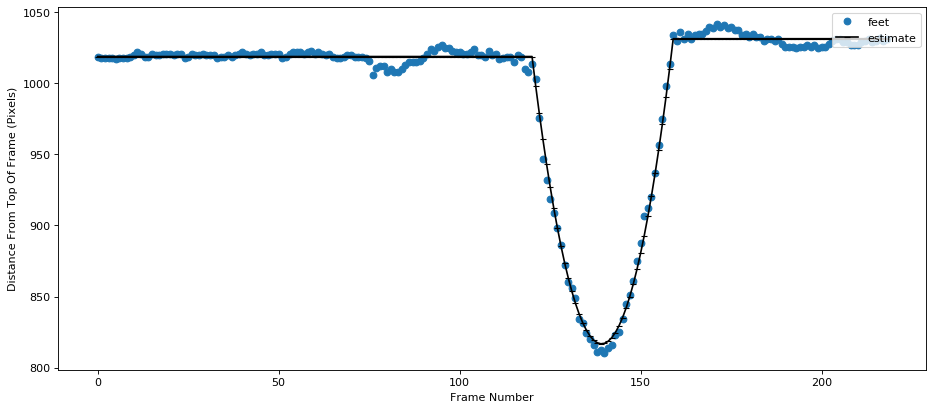

20.39037812499999

In [23]:
calcHeight("jump10.mp4", "gd3", plot=True)

In [24]:
def runTestbench(alg):
    """
    Run the MLE algorithm (feet only) on the entire database and compare to the ground truth
    
    Arguments:
    alg: string containing chosen algorithm, "bf"=brute force, "dp"=dynamic programming, "gd"=gradient descent
    
    Returns:
    none, prints the % error for each video clip, and average % error
    """
    directory = "videos"
    avgError = 0
    numTests = 0
    print("Algorithm: %s" % alg)
    for jump in glob.glob(directory + '/*.mp4'): # iterate through each video in the directory
        video_name = jump[(len(directory)+1):] # extract the video name (basename only) by slicing the path
        height = calcHeight(video_name, alg, plot=False) # compute jump height
        gt = groundTruth[video_name][0] # get the ground truth jump height
        error = 100*((height-gt)/gt) # compute % error
        print("%s: estimate: %f, ground_truth: %f, error: %f %%" %(video_name, height, gt, error))
        avgError += np.abs(error)
        numTests += 1
    
    avgError = avgError/numTests
    print("Average unsigned %% error: %f" % avgError)

Run the testbench on each MLE algorithm and record runtime

In [25]:
t0 = time.clock()
runTestbench("bf")
t1 = time.clock()
t = t1 - t0
print("runtime: %f seconds" %t)

C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Algorithm: bf
jump1.mp4: estimate: 17.374050, ground_truth: 20.390000, error: -14.791319 %
jump10.mp4: estimate: 20.390378, ground_truth: 20.390000, error: 0.001854 %
jump11.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump12.mp4: estimate: 16.422231, ground_truth: 17.370000, error: -5.456356 %
jump13.mp4: estimate: 13.727644, ground_truth: 14.600000, error: -5.975038 %
jump14.mp4: estimate: 14.599028, ground_truth: 17.370000, error: -15.952630 %
jump15.mp4: estimate: 13.727644, ground_truth: 13.730000, error: -0.017156 %
jump16.mp4: estimate: 18.352681, ground_truth: 19.340000, error: -5.105063 %
jump17.mp4: estimate: 15.497224, ground_truth: 19.340000, error: -19.869578 %
jump18.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump19.mp4: estimate: 17.374050, ground_truth: 17.340000, error: 0.196367 %
jump2.mp4: estimate: 18.352681, ground_truth: 20.390000, error: -9.991756 %
jump20.mp4: estimate: 16.422231, ground_truth: 16.420000, error

C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in long_scalars


jump26.mp4: estimate: 15.497224, ground_truth: 17.340000, error: -10.627315 %
jump27.mp4: estimate: 18.352681, ground_truth: 18.350000, error: 0.014610 %
jump28.mp4: estimate: 16.422231, ground_truth: 16.420000, error: 0.013586 %
jump29.mp4: estimate: 15.497224, ground_truth: 15.500000, error: -0.017912 %
jump3.mp4: estimate: 16.422231, ground_truth: 15.500000, error: 5.949877 %
jump30.mp4: estimate: 14.599028, ground_truth: 16.420000, error: -11.089963 %
jump31.mp4: estimate: 15.497224, ground_truth: 15.500000, error: -0.017912 %
jump32.mp4: estimate: 16.422231, ground_truth: 15.500000, error: 5.949877 %
jump4.mp4: estimate: 17.374050, ground_truth: 17.370000, error: 0.023316 %
jump5.mp4: estimate: 20.390378, ground_truth: 20.390000, error: 0.001854 %
jump6.mp4: estimate: 20.390378, ground_truth: 22.540000, error: -9.536920 %
jump7.mp4: estimate: 17.374050, ground_truth: 16.420000, error: 5.810292 %
jump8.mp4: estimate: 20.390378, ground_truth: 20.390000, error: 0.001854 %
jump9.mp4: 

C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
t0 = time.clock()
runTestbench("dp")
t1 = time.clock()
t = t1 - t0
print("runtime: %f seconds" %t)

Algorithm: dp
jump1.mp4: estimate: 18.352681, ground_truth: 20.390000, error: -9.991756 %
jump10.mp4: estimate: 19.358124, ground_truth: 20.390000, error: -5.060698 %
jump11.mp4: estimate: 13.727644, ground_truth: 14.600000, error: -5.975038 %
jump12.mp4: estimate: 16.422231, ground_truth: 17.370000, error: -5.456356 %
jump13.mp4: estimate: 13.727644, ground_truth: 14.600000, error: -5.975038 %
jump14.mp4: estimate: 13.727644, ground_truth: 17.370000, error: -20.969232 %
jump15.mp4: estimate: 13.727644, ground_truth: 13.730000, error: -0.017156 %


C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


jump16.mp4: estimate: 18.352681, ground_truth: 19.340000, error: -5.105063 %
jump17.mp4: estimate: 15.497224, ground_truth: 19.340000, error: -19.869578 %
jump18.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump19.mp4: estimate: 17.374050, ground_truth: 17.340000, error: 0.196367 %
jump2.mp4: estimate: 18.352681, ground_truth: 20.390000, error: -9.991756 %
jump20.mp4: estimate: 16.422231, ground_truth: 16.420000, error: 0.013586 %
jump21.mp4: estimate: 16.422231, ground_truth: 17.370000, error: -5.456356 %
jump22.mp4: estimate: 17.374050, ground_truth: 19.360000, error: -10.258006 %
jump23.mp4: estimate: 17.374050, ground_truth: 19.360000, error: -10.258006 %
jump24.mp4: estimate: 15.497224, ground_truth: 14.600000, error: 6.145367 %
jump25.mp4: estimate: 12.883073, ground_truth: 14.600000, error: -11.759777 %
jump26.mp4: estimate: 15.497224, ground_truth: 17.340000, error: -10.627315 %
jump27.mp4: estimate: 18.352681, ground_truth: 18.350000, error: 0.014610 %

C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
t0 = time.clock()
runTestbench("gd1")
t1 = time.clock()
t = t1 - t0
print("runtime: %f seconds" %t)

Algorithm: gd1
jump1.mp4: estimate: 17.374050, ground_truth: 20.390000, error: -14.791319 %


C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


jump10.mp4: estimate: 20.390378, ground_truth: 20.390000, error: 0.001854 %
jump11.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump12.mp4: estimate: 16.422231, ground_truth: 17.370000, error: -5.456356 %
jump13.mp4: estimate: 13.727644, ground_truth: 14.600000, error: -5.975038 %
jump14.mp4: estimate: 14.599028, ground_truth: 17.370000, error: -15.952630 %
jump15.mp4: estimate: 13.727644, ground_truth: 13.730000, error: -0.017156 %
jump16.mp4: estimate: 18.352681, ground_truth: 19.340000, error: -5.105063 %
jump17.mp4: estimate: 15.497224, ground_truth: 19.340000, error: -19.869578 %
jump18.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump19.mp4: estimate: 17.374050, ground_truth: 17.340000, error: 0.196367 %
jump2.mp4: estimate: 18.352681, ground_truth: 20.390000, error: -9.991756 %
jump20.mp4: estimate: 16.422231, ground_truth: 16.420000, error: 0.013586 %
jump21.mp4: estimate: 16.422231, ground_truth: 17.370000, error: -5.456356 %
j

C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
t0 = time.clock()
runTestbench("gd2")
t1 = time.clock()
t = t1 - t0
print("runtime: %f seconds" %t)

Algorithm: gd2


C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


jump1.mp4: estimate: 17.374050, ground_truth: 20.390000, error: -14.791319 %
jump10.mp4: estimate: 20.390378, ground_truth: 20.390000, error: 0.001854 %
jump11.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump12.mp4: estimate: 16.422231, ground_truth: 17.370000, error: -5.456356 %
jump13.mp4: estimate: 13.727644, ground_truth: 14.600000, error: -5.975038 %
jump14.mp4: estimate: 15.497224, ground_truth: 17.370000, error: -10.781672 %
jump15.mp4: estimate: 13.727644, ground_truth: 13.730000, error: -0.017156 %
jump16.mp4: estimate: 18.352681, ground_truth: 19.340000, error: -5.105063 %
jump17.mp4: estimate: 15.497224, ground_truth: 19.340000, error: -19.869578 %
jump18.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump19.mp4: estimate: 17.374050, ground_truth: 17.340000, error: 0.196367 %
jump2.mp4: estimate: 18.352681, ground_truth: 20.390000, error: -9.991756 %
jump20.mp4: estimate: 16.422231, ground_truth: 16.420000, error: 0.013586 %
j

C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
t0 = time.clock()
runTestbench("gd3")
t1 = time.clock()
t = t1 - t0
print("runtime: %f seconds" %t)

Algorithm: gd3
jump1.mp4: estimate: 19.358124, ground_truth: 20.390000, error: -5.060698 %
jump10.mp4: estimate: 20.390378, ground_truth: 20.390000, error: 0.001854 %

C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.



jump11.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump12.mp4: estimate: 16.422231, ground_truth: 17.370000, error: -5.456356 %
jump13.mp4: estimate: 13.727644, ground_truth: 14.600000, error: -5.975038 %
jump14.mp4: estimate: 15.497224, ground_truth: 17.370000, error: -10.781672 %
jump15.mp4: estimate: 13.727644, ground_truth: 13.730000, error: -0.017156 %
jump16.mp4: estimate: 18.352681, ground_truth: 19.340000, error: -5.105063 %
jump17.mp4: estimate: 15.497224, ground_truth: 19.340000, error: -19.869578 %
jump18.mp4: estimate: 14.599028, ground_truth: 14.600000, error: -0.006657 %
jump19.mp4: estimate: 17.374050, ground_truth: 17.340000, error: 0.196367 %
jump2.mp4: estimate: 20.390378, ground_truth: 20.390000, error: 0.001854 %
jump20.mp4: estimate: 16.422231, ground_truth: 16.420000, error: 0.013586 %
jump21.mp4: estimate: 17.374050, ground_truth: 17.370000, error: 0.023316 %
jump22.mp4: estimate: 17.374050, ground_truth: 19.360000, error: -10.258006 %


C:\Users\rkhar\Anaconda3\envs\e190SP\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


## I also attempted to use an approach similar to NMF, but it did not quite work out

It seemed like the error was not monotonically decreasing for some reason

In [346]:
def createH(f0, f1, length):
    """
    Creates the H matrix based on f0 and f1
    
    Arguments:
    f0: takeoff frame
    f1: landing frame
    length: number of points in the feet array
    
    Returns:
    H: the H matrix for NMF, row 0 corresponds to mu0, row 1 is for A, row 2 for B, row 3 for C, row4 for mu1
    """
    
    H = np.zeros((5,length))
    H[0,0:f0] = 1
    H[1,f0:f1+1] = np.arange(f0,f1+1)**2
    H[2,f0:f1+1] = -np.arange(f0,f1+1)
    H[3,f0:f1+1] = 1
    H[4,f1+1:] = 1
    
    return H

In [364]:
def nmf(V, W, H):
    """
    modified version of nmf where we iteratively update W, and hold H constant
    
    Arguments:
    V: observations
    W: "template" matrix containing parameters
    V: "activations" matrix containing the values necessary for the piecewise model
    
    Returns:
    Wnew: the optimized parameters for this given H matrix
    """
    
    epsilon = 1e-12 # avoid divide by zero
    Wnew = W
    Ht = np.transpose(H)
    numIterations = 100
    sigma = 1e-6
    
    for i in list(range(numIterations)):
        Wold = Wnew
        #update = (Wold@H@Ht - V@Ht)
        #gsigt = np.transpose(((Wold - sigma*update)@H@Ht - V@Ht))
        #stepsize = (sigma*(np.linalg.norm(update)**2))/(gsigt@update - (np.linalg.norm(update)**2))
        #Wnew = Wold + stepsize*update
        
        Wnew = Wold*(V@Ht)/(Wold@H@Ht + epsilon) # update W
        #print("update:")
        #print(stepsize*update)
        #print("Wnew:")
        #print(Wnew)
        
        error = np.sum((V - Wnew@H)**2)
        print("error: %f" %error)
        
    print("")
    
    return Wnew

In [365]:
def mle_nmf(feet, plot):
    """
    Uses gradient descent and a variation of NMF.  Does not assume that (h,k) is the minimum value.
    
    Arguments:
    feet:  time series feet data
    plot:  whether or not to generate a plot
    
    Returns:
    f0:  frame number at takeoff
    f1:  frame number at landing
    """
    
    length = len(feet) # number of frames
    minJump = 10 # 10 frames in the air is the minimum jump we allow (1.34 inches)
    
    # gradient descent approach to optimization
    errors = np.ones((length, length)) # store all errors in a 2d matrix (rows, cols)
    errors = errors*1e10 # initialize to a high value so that unused elements in the array are not selected
    
    # intitialize W
    mu0_init = 1000
    mu1_init = 1000
    A_init = 0.6
    B_init = 150
    C_init = 10000
    W = np.array([mu0_init, A_init, B_init, C_init, mu1_init])
    
    # initialize f0 and f1
    f0, f1 = mle_gd(feet, plot=False)
    
    minInd = (0,0) # initialize so we enter the while loop
    while (minInd != (1,1)): # while the current point is not the most optimal
        print("f0: %d, f1: %d" %(f0,f1))
        # create a grid of error values around the current point.  [1,1] is the point we are currently at
        # in the grid, col is f0 frame, row is f1 frame
        # save everything in a larger grid (errors) so we don't need to re-calculate anything
        grid = np.zeros((3,3))
        
        if (errors[f1,f0] == 1e10):
            H = createH(f0, f1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[1,1] = calcError(f0, f1, h, k, length, feet)
            errors[f1,f0] = grid[1,1]
        else:
            grid[1,1] = errors[f1,f0]
            
        if (errors[f1,f0+1] == 1e10):
            H = createH(f0+1, f1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[1,2] = calcError(f0+1, f1, h, k, length, feet)
            errors[f1,f0+1] = grid[1,2]
        else:
            grid[1,2] = errors[f1,f0+1]
            
        if (errors[f1-1,f0+1] == 1e10):
            H = createH(f0+1, f1-1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[2,2] = calcError(f0+1, f1-1, h, k, length, feet)
            errors[f1-1,f0+1] = grid[2,2]
        else:
            grid[2,2] = errors[f1-1,f0+1]
            
        if (errors[f1-1,f0] == 1e10):
            H = createH(f0, f1-1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[2,1] = calcError(f0, f1-1, h, k, length, feet)
            errors[f1-1,f0] = grid[2,1]
        else:
            grid[2,1] = errors[f1-1,f0]
            
        if (errors[f1-1,f0-1] == 1e10):
            H = createH(f0-1, f1-1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[2,0] = calcError(f0-1, f1-1, h, k, length, feet)
            errors[f1-1,f0-1] = grid[2,0]
        else:
            grid[2,0] = errors[f1-1,f0-1]
            
        if (errors[f1,f0-1] == 1e10):
            H = createH(f0-1, f1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[1,0] = calcError(f0-1, f1, h, k, length, feet)
            errors[f1,f0-1] = grid[1,0]
        else:
            grid[1,0] = errors[f1,f0-1]
            
        if (errors[f1+1,f0-1] == 1e10):
            H = createH(f0-1, f1+1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[0,0] = calcError(f0-1, f1+1, h, k, length, feet)
            errors[f1+1,f0-1] = grid[0,0]
        else:
            grid[0,0] = errors[f1+1,f0-1]
            
        if (errors[f1+1,f0] == 1e10):
            H = createH(f0, f1+1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[0,1] = calcError(f0, f1+1, h, k, length, feet)
            errors[f1+1,f0] = grid[0,1]
        else:
            grid[0,1] = errors[f1+1,f0]
            
        if (errors[f1+1,f0+1] == 1e10):
            H = createH(f0+1, f1+1, length)
            mu0, A, B, C, mu1 = nmf(feet, W, H)
            h = B/(2*A)
            k = C - A*(h**2)
            grid[0,2] = calcError(f0+1, f1+1, h, k, length, feet)
            errors[f1+1,f0+1] = grid[0,2]
        else:
            grid[0,2] = errors[f1+1,f0+1]
        
        # move in the direction of least error
        minInd = np.unravel_index(np.argmin(grid, axis=None), grid.shape)
        f1 = f1 + (1-minInd[0]) # because a higher index in grid means decreasing f1 frame number
        f0 = f0 + (minInd[1]-1) # because a higher index in grid means an increasing f0 frame number
    
    
    H = createH(f0, f1, length)
    mu0, A, B, C, mu1 = nmf(feet, W, H)
    h = B/(2*A)
    k = C - A*(h**2)
    
    # plot the results
    if (plot==True):
        mu0 = np.average(feet[0:f0+1])
        mu1 = np.average(feet[f1:])
        plotEstimate(feet, f0, mu0, h, k, f1, mu1, length)
    
    return f0, f1

f0: 108, f1: 145
error: 32843.979156
error: 30648.751995
error: 29396.587788
error: 28747.664984
error: 28486.152829
error: 28474.869743
error: 28626.599285
error: 28885.909694
error: 29217.610100
error: 29599.409535
error: 30017.243127
error: 30462.294024
error: 30929.094956
error: 31414.317932
error: 31916.002819
error: 32433.065945
error: 32964.987373
error: 33511.612163
error: 34073.024337
error: 34649.467178
error: 35241.293068
error: 35848.932136
error: 36472.872877
error: 37113.650422
error: 37771.839667
error: 38448.051536
error: 39142.931250
error: 39857.157914
error: 40591.444976
error: 41346.541289
error: 42123.232599
error: 42922.343372
error: 43744.738883
error: 44591.327546
error: 45463.063472
error: 46360.949242
error: 47286.038916
error: 48239.441275
error: 49222.323320
error: 50235.914047
error: 51281.508517
error: 52360.472253
error: 53474.245984
error: 54624.350775
error: 55812.393584
error: 57040.073277
error: 58309.187140
error: 59621.637967
error: 60979.441739
err

error: 66077.386303
error: 67702.155143
error: 69387.922927
error: 71137.821598
error: 72955.192052
error: 74843.601485
error: 76806.862488
error: 78849.054079
error: 80974.544914
error: 83188.018935
error: 85494.503762
error: 87899.402176
error: 90408.527082
error: 93028.140415
error: 95764.996508
error: 98626.390528
error: 101620.212684
error: 104755.009006
error: 108040.049654
error: 111485.405851
error: 115102.036730
error: 118901.887597
error: 122898.001420
error: 127104.645602
error: 131537.456580
error: 136213.605173
error: 141151.986247
error: 146373.436933
error: 151900.988499
error: 157760.158070
error: 163979.287671
error: 170589.939770
error: 177627.360502
error: 185131.024441
error: 193145.278003
error: 201720.102876
error: 210912.026210
error: 220785.211386
error: 231412.772282
error: 242878.366003
error: 255278.134947
error: 268723.090394
error: 283342.058523
error: 299285.348959
error: 316729.359995
error: 335882.409921
error: 356992.190363
error: 380355.389818
error: 4

error: 33293.957650
error: 33445.480674
error: 33599.134815
error: 33754.960140
error: 33912.997678
error: 34073.289452
error: 34235.878507
error: 34400.808939
error: 34568.125929
error: 34737.875774
error: 34910.105924
error: 35084.865013
error: 35262.202899
error: 35442.170700
error: 35624.820832
error: 35810.207054
error: 35998.384506
error: 36189.409754
error: 36383.340836
error: 36580.237310
error: 36780.160301
error: 36983.172552
error: 37189.338478
error: 37398.724221

error: 35792.210781
error: 32399.109975
error: 30010.334832
error: 28336.851977
error: 27172.988592
error: 26372.397576
error: 25830.927734
error: 25474.437999
error: 25250.135595
error: 25120.419890
error: 25058.506022
error: 25045.312373
error: 25067.245760
error: 25114.624592
error: 25180.555700
error: 25260.133976
error: 25349.871875
error: 25447.292653
error: 25550.640316
error: 25658.672779
error: 25770.514363
error: 25885.550621
error: 26003.353360
error: 26123.627196
error: 26246.171475
error: 26370.853152

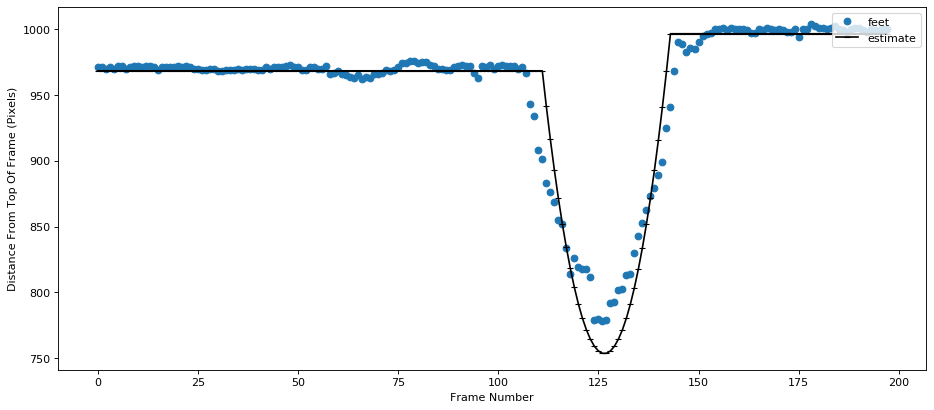

13.727644444444438

In [366]:
calcHeight("jump2.mp4", "nmf", plot=True)